In [168]:
input_cardinality=20
output_cardinality=15 #set values from integers in [1,2,3,4,5,6,7,8,9,10,15,20]

In [182]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as sk
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import joblib

In [183]:
#import pytorch_lightning as pl
import time
import copy
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow


In [184]:
torch.manual_seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
tensorflow.random.set_seed(1234)

In [185]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [186]:
class DATA:
    def __init__(self, data_path):
        self.data_path = data_path
        self.cols = 'ThetaXHG'
    def get_data(self):
        return self.read_data()
    
    def read_data(self): #polymorphism
        return pd.read_csv(self.data_path)

In [187]:
DATA_PATH = "../DATASET/REALTIME_DATA/alldata.csv"
data = DATA(DATA_PATH)
samples = data.get_data()

In [188]:
samples

,HG_J0,HG_J1,HG_J2,HG_J3,HG_J4,HG_J5,HG_J6,HG_J7,HG_J8,HG_J9,...,RH_J9,RH_J10,RH_J11,RH_J12,RH_J13,RH_J14,RH_J15,ThetaXHG,ThetaYHG,ThetaZHG
0,0.545,0.724681,0.567105,0.416667,0.624017,0.608333,0.506329,0.308333,0.378247,1,...,-0.195763,0.693640,0,1.466225,0.223258,-0.292838,1.687952,-0.001207,0,0
1,0.545,0.724681,0.567105,0.421667,0.624891,0.615000,0.508075,0.315000,0.380009,1,...,-0.195763,0.693640,0,1.466050,0.223212,-0.292807,1.687925,0.009104,0,0
2,0.545,0.724431,0.566667,0.420000,0.624891,0.611667,0.508075,0.311667,0.380889,1,...,-0.195763,0.693640,0,1.465492,0.223066,-0.292705,1.687838,0.005889,0,0
3,0.545,0.724181,0.566228,0.421667,0.624891,0.610000,0.508512,0.310000,0.383972,1,...,-0.195763,0.693640,0,1.465392,0.223040,-0.292687,1.687823,0.007015,0,0
4,0.545,0.724181,0.566228,0.425000,0.624891,0.613333,0.508512,0.311667,0.383972,1,...,-0.195763,0.693640,0,1.465212,0.222993,-0.292654,1.687794,0.011417,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,0.547,0.692923,0.369298,0.665000,0.772489,0.691667,0.721955,0.413333,0.663144,1,...,-0.217956,0.695774,0,1.435448,0.220266,-0.285573,1.676194,0.330298,0,0
1444,0.547,0.692673,0.367982,0.665000,0.772489,0.691667,0.724138,0.413333,0.665346,1,...,-0.217956,0.695774,0,1.425746,0.217689,-0.283673,1.673708,0.335613,0,0
1445,0.547,0.692923,0.367544,0.665000,0.772489,0.691667,0.724138,0.413333,0.665346,1,...,-0.217956,0.695774,0,1.418387,0.215728,-0.282196,1.671575,0.336424,0,0
1446,0.547,0.692923,0.367544,0.665000,0.772489,0.691667,0.724138,0.413333,0.665786,1,...,-0.217956,0.695774,0,1.412639,0.214192,-0.281020,1.669761,0.336424,0,0


In [189]:
model_ckp_path = "../TRANSFORMER_CHECKPOINTS/transformer_lookahead"+str(output_cardinality)+".model"
scaler_filename = "../TRANSFORMER_SCALER_DUMPS/transformer_min_max_scaler_lookahead"+str(output_cardinality)+".save"
batch_size = 1


In [190]:
transformer_predictor_realtime = tensorflow.keras.models.load_model(model_ckp_path)
scaler = joblib.load(scaler_filename) 


In [191]:
from tqdm import tqdm

In [193]:
#Generate predictions
j = input_cardinality
prediction_mismatch = list()
columns_= ['ThetaXHG_PREDICTION', 'ThetaXHG_GROUND']
for i in tqdm(range(samples[data.cols].shape[0]-input_cardinality+1)):
    X = samples[data.cols][i:i+input_cardinality]    
    if j <=samples[data.cols].shape[0]-1:
        y_ground = samples[data.cols][i+input_cardinality]
    else:
        y_ground = ''
    X_scaled = scaler.transform(X.to_numpy().reshape(X.shape[0],1))
    #X_torch_scaled = torch.tensor(X_scaled.transpose(), dtype=torch.float64)
    y_pred_scaled = transformer_predictor_realtime.predict(X_scaled.transpose(), verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    #print(y_ground, y_pred)
    prediction_mismatch.append([y_pred[0][output_cardinality-1],y_ground])
    j +=1

100%|███████████████████████████████████████| 1429/1429 [00:54<00:00, 26.03it/s]


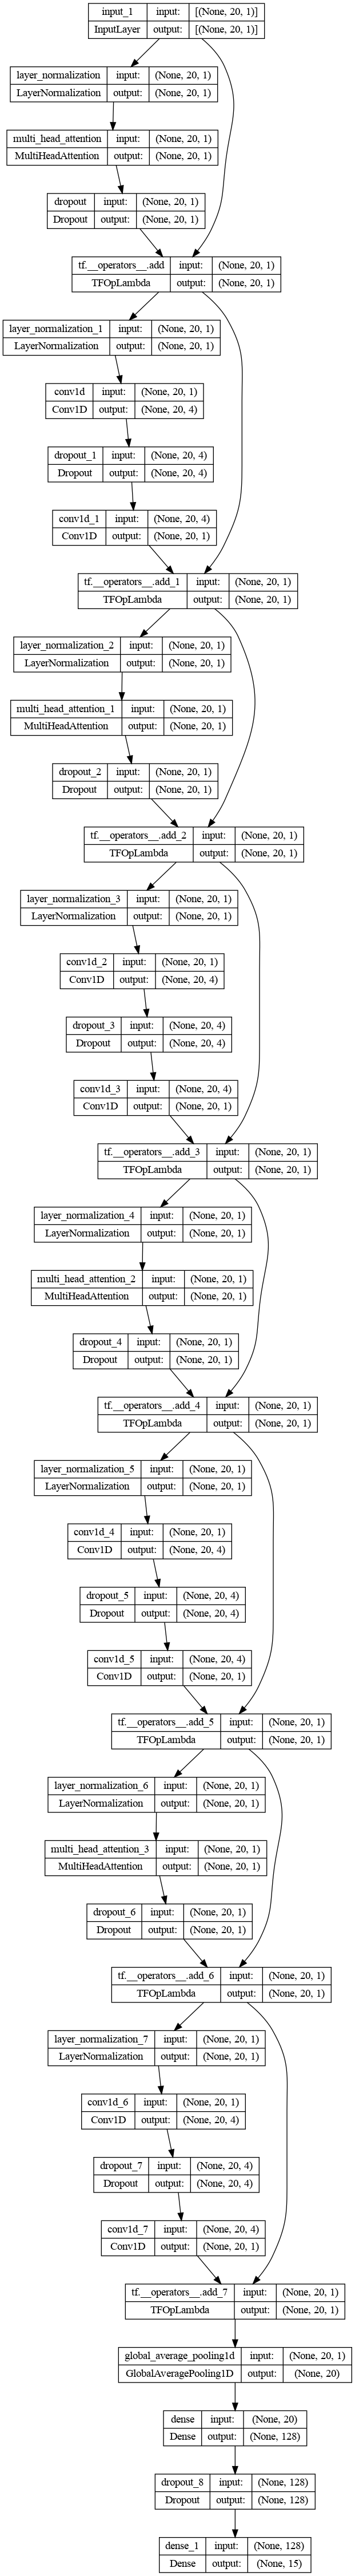

In [195]:
from keras.utils.vis_utils import plot_model
plot_model(transformer_predictor_realtime, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [203]:
import visualkeras
visualkeras.layered_view(transformer_predictor_realtime)

TypeError: 'int' object is not iterable

In [180]:
import os
if not os.path.exists("../TRANSFORMER_RESULTS_PREDICTION"):
    os.mkdir("../TRANSFORMER_RESULTS_PREDICTION")

In [181]:
pd.DataFrame(prediction_mismatch, columns=columns_).to_csv('../TRANSFORMER_RESULTS_PREDICTION/TRANSFORMER_PREDICTION_lookahead'+str(output_cardinality)+".csv", index=False)